   Kode Pos  R  F  M  T        Segment
0     80236  1  5  5  5  Loyal Spender
1     80237  5  4  3  1  Loyal Spender
2     80238  1  2  2  3    Hibernating
3     80239  1  5  5  4  Loyal Spender
4     80240  4  1  1  2   New Customer
5     80241  3  3  4  4      Promising
6     80242  5  1  1  1   New Customer
7     80243  4  2  2  2   New Customer
8     80244  1  3  3  3        Churner
9     80245  3  4  4  5  Loyal Spender

Skor RFMT (nilai asli sebelum diskretisasi):
   Kode Pos  Recency  Frequency   Monetary  Tenure
0     80236      122        123  200100000    1069
1     80237      133         93  140200000     979
2     80238      122         49   73500000    1004
3     80239      119        110  176300000    1019
4     80240      129         39   62900000     988
5     80241      124         92  148900000    1024
6     80242      131         28   44800000     942
7     80243      127         56   87300000     997
8     80244      122         79  126200000    1013
9     80245    

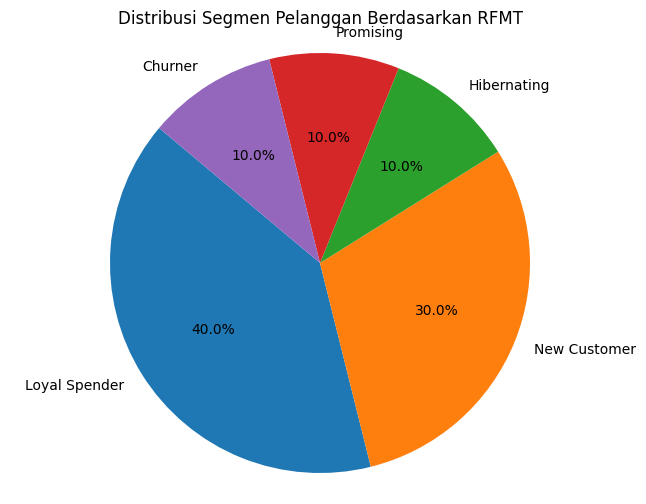

C:\Users\Andndre\AppData\Local\Temp\ipykernel_13068\2729176922.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfmt_final, y='Segment', order=rfmt_final['Segment'].value_counts().index, palette='viridis')


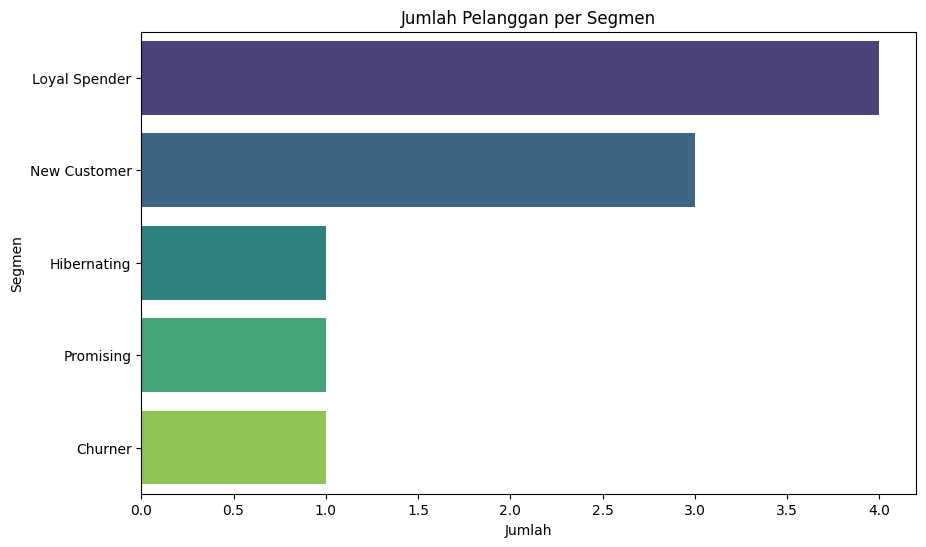

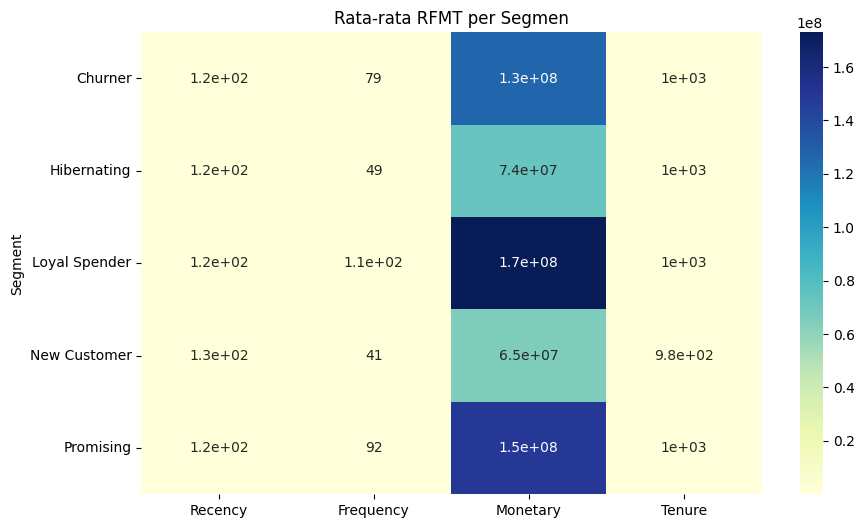

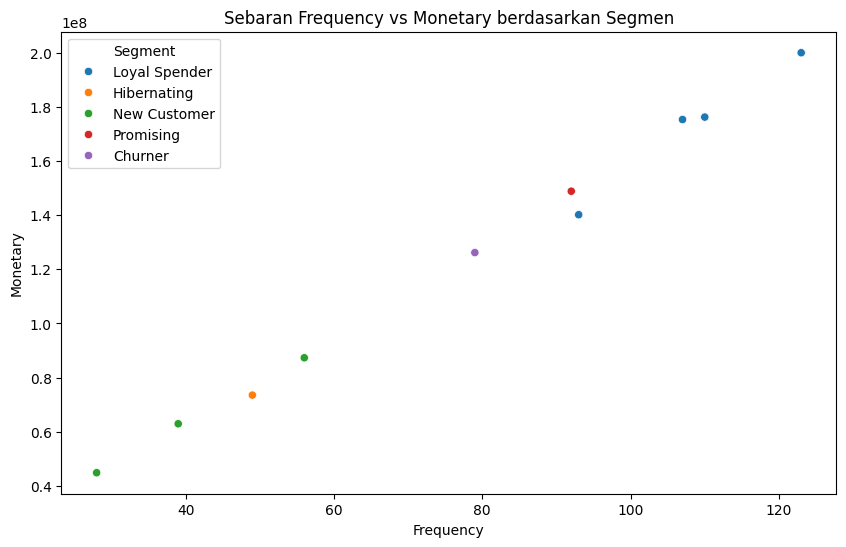

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Baca dan siapkan data
df = pd.read_csv('data_pelanggan_sampel.csv')
df['Tanggal Transaksi Terakhir'] = pd.to_datetime(df['Tanggal Transaksi Terakhir'])
df['Tanggal Transaksi Pertama'] = pd.to_datetime(df['Tanggal Transaksi Pertama'])
today = pd.Timestamp(datetime.today().date())

# 2. Hitung RFMT
df['Recency'] = (today - df['Tanggal Transaksi Terakhir']).dt.days
df['Frequency'] = df['Frekuensi Pembelian']
df['Monetary'] = df['Total Pembelian (Rp)']
df['Tenure'] = (today - df['Tanggal Transaksi Pertama']).dt.days

# 3. Agregasi per kode pos
rfmt_agg = df.groupby('Kode Pos').agg({
    'Recency': 'min',
    'Frequency': 'sum',
    'Monetary': 'sum',
    'Tenure': 'max'
}).reset_index()

# 4. Z-score normalization
scaler = StandardScaler()
rfmt_values = rfmt_agg[['Recency', 'Frequency', 'Monetary', 'Tenure']]
rfmt_scaled = scaler.fit_transform(rfmt_values)
rfmt_scaled_df = pd.DataFrame(rfmt_scaled, columns=['R_z', 'F_z', 'M_z', 'T_z'])

# 5. Skor 1-5 berdasarkan z-score (binned secara kuantil)
rfmt_scores = rfmt_scaled_df.copy()
for col in rfmt_scores.columns:
    rfmt_scores[col] = pd.qcut(rfmt_scores[col], 5, labels=[1, 2, 3, 4, 5])

# 6. Gabungkan ke data utama
rfmt_final = pd.concat([rfmt_agg, rfmt_scores], axis=1)
rfmt_final.rename(columns={'R_z': 'R', 'F_z': 'F', 'M_z': 'M', 'T_z': 'T'}, inplace=True)

# 7. Segmentasi manual
def assign_segment(row):
    r, f, m, t = int(row['R']), int(row['F']), int(row['M']), int(row['T'])
    if r >= 4 and f >= 4 and m >= 4:
        return 'Best Customer'
    elif f >= 4 and m >= 3:
        return 'Loyal Spender'
    elif r >= 4 and (f >= 3 or t >= 3):
        return 'Potential Loyalist'
    elif r >= 4:
        return 'New Customer'
    elif f >= 4:
        return 'Loyal Customer'
    elif r >= 3 and f >= 2:
        return 'Promising'
    elif r >= 2 and (f >= 2 or t >= 2):
        return 'Can Not Lose'
    elif r == 2 and f <= 2:
        return 'About to Sleep'
    elif r == 1 and f <= 2:
        return 'Hibernating'
    else:
        return 'Churner'

rfmt_final['Segment'] = rfmt_final.apply(assign_segment, axis=1)

# 8. Tampilkan hasil
print(rfmt_final[['Kode Pos', 'R', 'F', 'M', 'T', 'Segment']].head(10))

# 9. Tampilkan hasil RFMT asli
print("\nSkor RFMT (nilai asli sebelum diskretisasi):")
print(rfmt_final[['Kode Pos', 'Recency', 'Frequency', 'Monetary', 'Tenure']].head(10))

# 10. Visualisasi pie chart segmen pelanggan
import matplotlib.pyplot as plt

segment_counts = rfmt_final['Segment'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Segmen Pelanggan Berdasarkan RFMT')
plt.axis('equal')
plt.show()

# 11. Bar chart untuk jumlah pelanggan per segmen
plt.figure(figsize=(10, 6))
sns.countplot(data=rfmt_final, y='Segment', order=rfmt_final['Segment'].value_counts().index, palette='viridis')
plt.title('Jumlah Pelanggan per Segmen')
plt.xlabel('Jumlah')
plt.ylabel('Segmen')
plt.show()

# 12. Heatmap
import seaborn as sns
rfmt_avg = rfmt_final.groupby("Segment")[['Recency', 'Frequency', 'Monetary', 'Tenure']].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(rfmt_avg, annot=True, cmap='YlGnBu')
plt.title("Rata-rata RFMT per Segmen")
plt.show()

# 13. Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfmt_final, x='Frequency', y='Monetary', hue='Segment', palette='tab10')
plt.title('Sebaran Frequency vs Monetary berdasarkan Segmen')
plt.show()

